In [55]:
# Import des bibliothèques nécessaires
from datasets import load_dataset
from datasets import concatenate_datasets
from transformers import AutoModel
import torch
import os
from huggingface_hub import login
import pandas as pd
import numpy as np

# Authentification à Hugging Face (nécessaire pour accéder aux datasets)
# Vous devrez avoir généré un token sur https://huggingface.co/settings/tokens
# et exécuté `huggingface-cli login` en ligne de commande avant de lancer ce script
# ou utiliser la méthode ci-dessous avec votre token

# Décommentez et ajoutez votre token si vous n'avez pas fait login via CLI
# login(token="votre_token_huggingface")

def load_and_prepare_datasets():
    """
    Charge les datasets ALOHA (transfer et insertion), ajoute un encodage de tâche,
    et concatène les données en un vecteur d'entrée de 101 dimensions.
    """
    print("Chargement des datasets...")
    ds_transfer = load_dataset("lerobot/aloha_sim_transfer_cube_human")
    ds_insertion = load_dataset("lerobot/aloha_sim_insertion_human")

    def process_example(example, task_tag):
        """
        Prépare un vecteur d'entrée de 101 dimensions pour chaque exemple.
        """
        obs = np.array(example["observation.state"], dtype=np.float32)
        act = np.array(example["action"], dtype=np.float32)
        
        # One-hot encoding simple pour 2 classes : [1, 0] pour transfer, [0, 1] pour insertion
        task_one_hot = np.array([1, 0], dtype=np.float32) if task_tag == "transfer" else np.array([0, 1], dtype=np.float32)
        
        # Concaténation des features
        combined = np.concatenate([obs, act, task_one_hot])
        
        # Padding si nécessaire (ici on pad jusqu'à 101 dim)
        padding_length = 101 - combined.shape[0]
        if padding_length > 0:
            combined = np.concatenate([combined, np.zeros(padding_length, dtype=np.float32)])
        
        # Ajoute un champ "input_vector" pour l'entraînement
        example["input_vector"] = combined
        return example

    def preprocess_dataset(dataset, task_tag):
        return dataset.map(lambda ex: process_example(ex, task_tag))

    print("Prétraitement des datasets...")
    processed_transfer = preprocess_dataset(ds_transfer["train"], "transfer")
    processed_insertion = preprocess_dataset(ds_insertion["train"], "insertion")

    print("Concaténation des datasets...")
    combined_dataset = concatenate_datasets([processed_transfer, processed_insertion])

    print(f"Nombre total d'échantillons : {len(combined_dataset)}")
    print("Exemple d'input_vector (shape) :", torch.tensor(combined_dataset[0]["input_vector"]).shape)
    
    return combined_dataset

# Exécution de la fonction de préparation des datasets
if __name__ == "__main__":
    combined_dataset = load_and_prepare_datasets()
    
    # Exemple d'accès aux données du dataset combiné
    if "train" in combined_dataset:
        train_split = combined_dataset["train"]
        
        # Comptage des échantillons par type de tâche
        task_counts = train_split.to_pandas()["task_tag"].value_counts()
        print("\nRépartition des tâches dans le split 'train':")
        print(task_counts)
        
        # Échantillon aléatoire pour vérification
        print("\nExemple d'échantillon du dataset combiné:")
        random_sample = train_split[np.random.randint(0, len(train_split))]
        print(f"Tâche: {random_sample['task_tag']}")
        for key in random_sample:
            if key != "task_tag" and isinstance(random_sample[key], (int, float, str, bool)):
                print(f"{key}: {random_sample[key]}")

Chargement des datasets...


Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Prétraitement des datasets...


Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Concaténation des datasets...
Nombre total d'échantillons : 45000
Exemple d'input_vector (shape) : torch.Size([101])


In [64]:
#New dataset creation function
from datasets import load_dataset, concatenate_datasets, DatasetDict
import numpy as np
import torch

def load_and_prepare_datasets():
    """
    Charge les datasets ALOHA (transfer et insertion), ajoute un encodage de tâche,
    et concatène les données en un vecteur d'entrée de 101 dimensions.
    """
    print("Chargement des datasets...")
    ds_transfer = load_dataset("lerobot/aloha_sim_transfer_cube_human")
    ds_insertion = load_dataset("lerobot/aloha_sim_insertion_human")

    def process_example(example, task_tag):
        """
        Prépare un vecteur d'entrée de 101 dimensions pour chaque exemple.
        """
        obs = np.array(example["observation.state"], dtype=np.float32)
        act = np.array(example["action"], dtype=np.float32)
        
        # One-hot encoding simple pour 2 classes : [1, 0] pour transfer, [0, 1] pour insertion
        task_one_hot = np.array([1, 0], dtype=np.float32) if task_tag == "transfer" else np.array([0, 1], dtype=np.float32)
        
        # Concaténation des features
        combined = np.concatenate([obs, act, task_one_hot])
        
        # Padding si nécessaire (ici on pad jusqu'à 101 dim)
        padding_length = 101 - combined.shape[0]
        if padding_length > 0:
            combined = np.concatenate([combined, np.zeros(padding_length, dtype=np.float32)])
        
        # Ajoute un champ "input_vector" pour l'entraînement
        example["input_vector"] = combined
        return example

    def preprocess_dataset(dataset, task_tag):
        return dataset.map(lambda ex: process_example(ex, task_tag))

    print("Prétraitement des datasets...")
    processed_transfer = preprocess_dataset(ds_transfer["train"], "transfer")
    processed_insertion = preprocess_dataset(ds_insertion["train"], "insertion")

    print("Concaténation des datasets...")
    combined_dataset = concatenate_datasets([processed_transfer, processed_insertion])

    print(f"Nombre total d'échantillons : {len(combined_dataset)}")
    print("Exemple d'input_vector (shape) :", torch.tensor(combined_dataset[0]["input_vector"]).shape)
    
    return combined_dataset

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ActModel(nn.Module):
    def __init__(
        self,
        obs_dim=101,       # tu devras adapter ces dimensions selon ton cas
        action_dim=7,
        hidden_dim=512,
        n_layers=4,
        dropout=0.1,
        use_layer_norm=True,
    ):
        super().__init__()
        self.obs_dim = obs_dim
        self.action_dim = action_dim

        self.input_layer = nn.Linear(obs_dim, hidden_dim)
        self.transformer_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=hidden_dim,
                nhead=8,
                dim_feedforward=hidden_dim * 4,
                dropout=dropout,
                batch_first=True,
                norm_first=use_layer_norm,
            ) for _ in range(n_layers)
        ])
        self.output_layer = nn.Linear(hidden_dim, action_dim)

    def forward(self, obs):
        x = self.input_layer(obs)
        for layer in self.transformer_layers:
            x = layer(x)
        return self.output_layer(x)

In [66]:
from safetensors.torch import load_file

def load_act_model(model_path):
    model = ActModel(
        obs_dim=101,       # adapte ces valeurs si nécessaire
        action_dim=7,
        hidden_dim=512,
        n_layers=4,
        dropout=0.1,
        use_layer_norm=True
    )

    state_dict = load_file(model_path)
    model.load_state_dict(state_dict, strict=False)
    return model

In [67]:
transfer_model = load_act_model("/Users/louloute/PycharmProjects/INF8225_projet/Models/transfer/model.safetensors")
insertion_model = load_act_model("/Users/louloute/PycharmProjects/INF8225_projet/Models/insertion/model.safetensors")
print(transfer_model)

ActModel(
  (input_layer): Linear(in_features=101, out_features=512, bias=True)
  (transformer_layers): ModuleList(
    (0-3): 4 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (linear1): Linear(in_features=512, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=512, bias=True)
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (output_layer): Linear(in_features=512, out_features=7, bias=True)
)


In [99]:
import torch
import torch.nn as nn

class UnifiedALOHAModel(nn.Module):
    def __init__(self, transfer_model, insertion_model, output_dim=14):  # Changé de 768 à 14
        super(UnifiedALOHAModel, self).__init__()

        self.transfer_model = transfer_model
        self.insertion_model = insertion_model

        for param in self.transfer_model.parameters():
            param.requires_grad = False

        for param in self.insertion_model.parameters():
            param.requires_grad = False

        # On suppose que les modèles retournent un vecteur de même taille que la dernière couche
        # Pour éviter les erreurs, on utilise une passe fictive pour obtenir la dimension de sortie réelle
        # Passe fictive pour obtenir les dimensions de sortie
        dummy_input = torch.randn(1, 101) 
        with torch.no_grad():
            transfer_out = self.transfer_model(dummy_input)
            insertion_out = self.insertion_model(dummy_input)
        
        # Si la sortie est un tuple (ex: (out, hidden)), on garde out
        if isinstance(transfer_out, tuple):
            transfer_out = transfer_out[0]
        if isinstance(insertion_out, tuple):
            insertion_out = insertion_out[0]
        
        transfer_output_size = transfer_out.shape[1]
        insertion_output_size = insertion_out.shape[1]
        
        # Supprimé la répétition du calcul des dimensions
        transfer_dim = transfer_output_size
        insertion_dim = insertion_output_size

        self.task_embedding = nn.Embedding(2, 64)  # Embedding pour la tâche (0 ou 1)

        self.fusion_layer = nn.Sequential(
            nn.Linear(transfer_dim + insertion_dim + 64, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        self.output_layer = nn.Linear(256, output_dim)  # Sortie maintenant en dimension 14
        self.layer_norm = nn.LayerNorm(output_dim)

    def forward(self, features, task_id=None):  
        """
        Args:
            features: (batch_size, input_dim)
            task_id: (batch_size, 1) ou (batch_size,) — type long ou None
    
        Returns:
            (batch_size, output_dim)
        """
        batch_size = features.size(0)
        
        if task_id is not None:
            task_emb = self.task_embedding(task_id.view(-1))  # (batch_size, 64)
        else:
            # Si task_id n'est pas fourni, on utilise un vecteur nul ou moyen
            task_emb = torch.zeros(batch_size, self.task_embedding.embedding_dim, device=features.device)
        
        with torch.no_grad():
            transfer_out = self.transfer_model(features)  # (batch_size, transfer_dim)
            insertion_out = self.insertion_model(features)  # (batch_size, insertion_dim)
        
        if isinstance(transfer_out, tuple):
            transfer_out = transfer_out[0]
        if isinstance(insertion_out, tuple):
            insertion_out = insertion_out[0]
        
        combined = torch.cat([transfer_out, insertion_out, task_emb], dim=1)  # (batch_size, total_dim)
        fused = self.fusion_layer(combined)
        output = self.output_layer(fused)
        output = self.layer_norm(output)
        
        return output

In [100]:
# Import des bibliothèques nécessaires
from transformers import AutoModel, AutoConfig, PreTrainedModel
import torch
import torch.nn as nn
from datasets import load_dataset
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import os
import wandb  # Pour le suivi des expériences (optionnel)
import matplotlib.pyplot as plt
from dataset import ALOHADataset

# Fonction pour l'entraînement du modèle unifié
def train_unified_model(unified_model, train_dataloader, val_dataloader, 
                        num_epochs=10, learning_rate=1e-4, device="cuda"):
    """
    Entraîne le modèle unifié.
    
    Args:
        unified_model: Le modèle unifié
        train_dataloader: DataLoader pour les données d'entraînement
        val_dataloader: DataLoader pour les données de validation
        num_epochs: Nombre d'époques d'entraînement
        learning_rate: Taux d'apprentissage
        device: Appareil sur lequel effectuer l'entraînement ('cuda' ou 'cpu')
    
    Returns:
        Le modèle entraîné et les historiques de perte
    """
    unified_model = unified_model.to(device)

    criterion = nn.MSELoss()  # À adapter si classification
    optimizer = torch.optim.Adam(unified_model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        unified_model.train()
        epoch_train_loss = 0.0
        train_batches = 0

        for batch in tqdm(train_dataloader, desc=f"Époque {epoch+1}/{num_epochs} (entraînement)"):
            features = batch["features"].float().to(device)
            labels = batch["labels"].float().to(device)

            optimizer.zero_grad()
            outputs = unified_model(features)
            loss = criterion(outputs, labels)
            loss.backward()

            # Optionnel : clip grad pour éviter les explosions de gradient
            torch.nn.utils.clip_grad_norm_(unified_model.parameters(), max_norm=1.0)

            optimizer.step()
            epoch_train_loss += loss.item()
            train_batches += 1

        epoch_train_loss /= train_batches
        train_losses.append(epoch_train_loss)

        unified_model.eval()
        epoch_val_loss = 0.0
        val_batches = 0
        print("features shape:", features.shape)  # debug

        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f"Époque {epoch+1}/{num_epochs} (validation)"):
                features = batch["features"].float().to(device)
                labels = batch["labels"].float().to(device)

                outputs = unified_model(features)
                loss = criterion(outputs, labels)
                epoch_val_loss += loss.item()
                val_batches += 1

        epoch_val_loss /= val_batches
        val_losses.append(epoch_val_loss)
        scheduler.step(epoch_val_loss)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Époque {epoch+1}/{num_epochs} - "
              f"LR: {current_lr:.2e} | "
              f"Train Loss: {epoch_train_loss:.6f} | "
              f"Val Loss: {epoch_val_loss:.6f}")

    return unified_model, train_losses, val_losses



In [101]:
# Fonction pour fine-tuner le modèle unifié (dégeler certaines couches)
def fine_tune_unified_model(unified_model, train_dataloader, val_dataloader, 
                           num_epochs=5, learning_rate=5e-5, device="cuda"):
    """
    Fine-tune le modèle unifié en dégelant certaines couches des modèles pré-entraînés.
    
    Args:
        unified_model: Le modèle unifié
        train_dataloader: DataLoader pour les données d'entraînement
        val_dataloader: DataLoader pour les données de validation
        num_epochs: Nombre d'époques d'entraînement
        learning_rate: Taux d'apprentissage
        device: Appareil sur lequel effectuer l'entraînement ('cuda' ou 'cpu')
    
    Returns:
        Le modèle fine-tuné et les historiques de perte
    """
    # Dégeler les dernières couches des modèles pré-entraînés
    for name, param in unified_model.transfer_model.named_parameters():
        if "layer" in name and any(f"layer.{i}" in name for i in [10, 11]):  # Dégeler les 2 dernières couches
            param.requires_grad = True
    
    for name, param in unified_model.insertion_model.named_parameters():
        if "layer" in name and any(f"layer.{i}" in name for i in [10, 11]):  # Dégeler les 2 dernières couches
            param.requires_grad = True
    
    # Entraîner le modèle avec les couches dégelées
    return train_unified_model(unified_model, train_dataloader, val_dataloader, 
                              num_epochs=num_epochs, learning_rate=learning_rate, device=device)

Chargement des datasets...


Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Prétraitement des datasets...
Concaténation des datasets...
Nombre total d'échantillons : 45000
Exemple d'input_vector (shape) : torch.Size([101])
Shape des features du premier exemple: torch.Size([101])
Utilisation de l'appareil: cpu

Entraînement du modèle unifié...


Époque 1/10 (entraînement): 100%|██████████| 1125/1125 [00:22<00:00, 49.59it/s]


features shape: torch.Size([32, 101])


Époque 1/10 (validation): 100%|██████████| 282/282 [00:04<00:00, 65.63it/s]


Époque 1/10 - LR: 1.00e-04 | Train Loss: 0.371158 | Val Loss: 0.220155


Époque 2/10 (entraînement): 100%|██████████| 1125/1125 [00:22<00:00, 49.58it/s]


features shape: torch.Size([32, 101])


Époque 2/10 (validation): 100%|██████████| 282/282 [00:04<00:00, 65.52it/s]


Époque 2/10 - LR: 1.00e-04 | Train Loss: 0.200435 | Val Loss: 0.111988


Époque 3/10 (entraînement): 100%|██████████| 1125/1125 [00:22<00:00, 49.72it/s]


features shape: torch.Size([32, 101])


Époque 3/10 (validation): 100%|██████████| 282/282 [00:04<00:00, 65.25it/s]


Époque 3/10 - LR: 1.00e-04 | Train Loss: 0.114258 | Val Loss: 0.060919


Époque 4/10 (entraînement): 100%|██████████| 1125/1125 [00:23<00:00, 47.96it/s]


features shape: torch.Size([32, 101])


Époque 4/10 (validation): 100%|██████████| 282/282 [00:04<00:00, 61.22it/s]


Époque 4/10 - LR: 1.00e-04 | Train Loss: 0.077594 | Val Loss: 0.044607


Époque 5/10 (entraînement): 100%|██████████| 1125/1125 [00:24<00:00, 46.67it/s]


features shape: torch.Size([32, 101])


Époque 5/10 (validation): 100%|██████████| 282/282 [00:04<00:00, 64.87it/s]


Époque 5/10 - LR: 1.00e-04 | Train Loss: 0.067010 | Val Loss: 0.041591


Époque 6/10 (entraînement): 100%|██████████| 1125/1125 [00:23<00:00, 47.43it/s]


features shape: torch.Size([32, 101])


Époque 6/10 (validation): 100%|██████████| 282/282 [00:04<00:00, 64.35it/s]


Époque 6/10 - LR: 1.00e-04 | Train Loss: 0.064476 | Val Loss: 0.039893


Époque 7/10 (entraînement): 100%|██████████| 1125/1125 [00:23<00:00, 47.30it/s]


features shape: torch.Size([32, 101])


Époque 7/10 (validation): 100%|██████████| 282/282 [00:04<00:00, 62.78it/s]


Époque 7/10 - LR: 1.00e-04 | Train Loss: 0.063504 | Val Loss: 0.038062


Époque 8/10 (entraînement): 100%|██████████| 1125/1125 [00:23<00:00, 47.49it/s]


features shape: torch.Size([32, 101])


Époque 8/10 (validation): 100%|██████████| 282/282 [00:04<00:00, 60.44it/s]


Époque 8/10 - LR: 1.00e-04 | Train Loss: 0.062821 | Val Loss: 0.037823


Époque 9/10 (entraînement): 100%|██████████| 1125/1125 [00:24<00:00, 45.78it/s]


features shape: torch.Size([32, 101])


Époque 9/10 (validation): 100%|██████████| 282/282 [00:04<00:00, 63.65it/s]


Époque 9/10 - LR: 1.00e-04 | Train Loss: 0.061907 | Val Loss: 0.036101


Époque 10/10 (entraînement): 100%|██████████| 1125/1125 [00:23<00:00, 47.75it/s]


features shape: torch.Size([32, 101])


Époque 10/10 (validation): 100%|██████████| 282/282 [00:04<00:00, 63.90it/s]


Époque 10/10 - LR: 1.00e-04 | Train Loss: 0.061273 | Val Loss: 0.035619

Fine-tuning du modèle unifié...


Époque 1/5 (entraînement): 100%|██████████| 1125/1125 [00:24<00:00, 46.51it/s]


features shape: torch.Size([32, 101])


Époque 1/5 (validation): 100%|██████████| 282/282 [00:04<00:00, 60.99it/s]


Époque 1/5 - LR: 5.00e-05 | Train Loss: 0.060914 | Val Loss: 0.035148


Époque 2/5 (entraînement): 100%|██████████| 1125/1125 [00:23<00:00, 47.54it/s]


features shape: torch.Size([32, 101])


Époque 2/5 (validation): 100%|██████████| 282/282 [00:04<00:00, 63.14it/s]


Époque 2/5 - LR: 5.00e-05 | Train Loss: 0.060638 | Val Loss: 0.034986


Époque 3/5 (entraînement): 100%|██████████| 1125/1125 [00:23<00:00, 47.75it/s]


features shape: torch.Size([32, 101])


Époque 3/5 (validation): 100%|██████████| 282/282 [00:04<00:00, 61.32it/s]


Époque 3/5 - LR: 5.00e-05 | Train Loss: 0.060672 | Val Loss: 0.034408


Époque 4/5 (entraînement): 100%|██████████| 1125/1125 [00:23<00:00, 47.19it/s]


features shape: torch.Size([32, 101])


Époque 4/5 (validation): 100%|██████████| 282/282 [00:04<00:00, 63.29it/s]


Époque 4/5 - LR: 5.00e-05 | Train Loss: 0.060171 | Val Loss: 0.033930


Époque 5/5 (entraînement): 100%|██████████| 1125/1125 [00:23<00:00, 46.88it/s]


features shape: torch.Size([32, 101])


Époque 5/5 (validation): 100%|██████████| 282/282 [00:04<00:00, 63.53it/s]


Époque 5/5 - LR: 5.00e-05 | Train Loss: 0.059618 | Val Loss: 0.033401


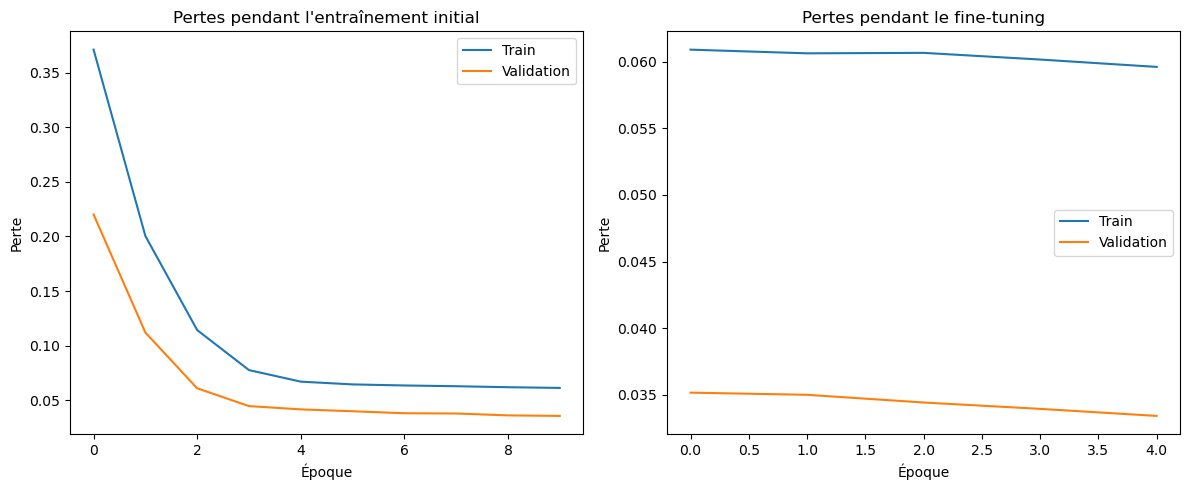

Modèle unifié sauvegardé dans unified_aloha_model


In [102]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import matplotlib.pyplot as plt
import os

# Dataset PyTorch à partir du champ input_vector
class ALOHADataset(Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        input_vector = torch.tensor(self.dataset[idx]["input_vector"], dtype=torch.float32)
        label = torch.tensor(self.dataset[idx]["action"], dtype=torch.float32)  # ou un autre champ si tu préfères
        return {
            "features": input_vector,
            "labels": label
        }

# Fonction principale
def main():
    # Charger le dataset combiné avec les vecteurs à 101 dimensions
    combined_dataset = load_and_prepare_datasets()

    # Créer l'objet Dataset PyTorch
    full_dataset = ALOHADataset(combined_dataset)
    
    # Split en train/val
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # 🔍 DEBUG : Afficher la forme des features d’un exemple
    sample = train_dataset[0]
    print(f"Shape des features du premier exemple: {sample['features'].shape}")

    # Créer les dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

    # Charger les modèles pré-entraînés
    transfer_model = load_act_model("/Users/louloute/PycharmProjects/INF8225_projet/Models/transfer/model.safetensors")
    insertion_model = load_act_model("/Users/louloute/PycharmProjects/INF8225_projet/Models/insertion/model.safetensors")

    # Créer le modèle unifié
    unified_model = UnifiedALOHAModel(transfer_model, insertion_model)

    # Déterminer l'appareil à utiliser
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Utilisation de l'appareil: {device}")

    # Entraîner le modèle unifié
    print("\nEntraînement du modèle unifié...")
    unified_model, train_losses, val_losses = train_unified_model(
        unified_model, train_dataloader, val_dataloader, 
        num_epochs=10, learning_rate=1e-4, device=device
    )

    # Fine-tuner le modèle unifié
    print("\nFine-tuning du modèle unifié...")
    unified_model, ft_train_losses, ft_val_losses = fine_tune_unified_model(
        unified_model, train_dataloader, val_dataloader, 
        num_epochs=5, learning_rate=5e-5, device=device
    )

    # Tracer les courbes de perte
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title('Pertes pendant l\'entraînement initial')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(ft_train_losses, label='Train')
    plt.plot(ft_val_losses, label='Validation')
    plt.title('Pertes pendant le fine-tuning')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_losses.png')
    plt.show()

    # Sauvegarde
    model_save_path = "unified_aloha_model"
    os.makedirs(model_save_path, exist_ok=True)
    torch.save(unified_model.state_dict(), os.path.join(model_save_path, "unified_model.pt"))
    print(f"Modèle unifié sauvegardé dans {model_save_path}")

if __name__ == "__main__":
    main()